In [173]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import math
from tqdm import tqdm_notebook as tqdm
%config InlineBackend.figure_formats = ['svg']
import pickle

In [127]:
colormap = {
    "incremental": "C0",
    "truncation": "C1",
    "pps": "C2",
    "random_sample": "C3",
    "spacesaving": "C4",
    "cms_min": "C5",
    "dyadic_truncation": "C6",
    "zero_est": "C7"
}
markers = {
    "incremental": "x",
    "truncation": "^",
    "pps": "s",
    "random_sample": "+",
    "spacesaving": "D",
    "cms_min": "o",
    "dyadic_truncation": "<",
    "zero_est": ">"
}
alg_display_name = {
    "incremental": "Greedy",
    "truncation": "Truncation",
    "pps": "PPS Sampling",
    "random_sample": "Simple Sampling",
    "spacesaving": "Space Saving Sketch",
    "cms_min": "CountMinSketch",
    "dyadic_truncation": "Dyadic Ranges",
    "zero_est": "Zero Estimator"
}

# Preprocessed

In [181]:
grains = [8, 32, 128, 512, 2048]
cum_results = []
for cur_grain in grains:
    print(cur_grain)
    with open("../output/cum_caida_{}.out".format(cur_grain), "rb") as f:
        results = pickle.load(f)
        cum_results.append(results)

8
32
128
512
2048


In [188]:
methods = [
    "incremental", 
    "pps", 
#     "spacesaving", 
    "cms_min", 
    "random_sample", 
    "truncation",
    "dyadic_truncation",
]
def plot_range_results(query_ranges):
    method_results = {
        "random_sample": [],
        "truncation": [],
        "pps": [],
        "incremental": [],
        "spacesaving": [],
        "cms_min": [],
        "dyadic_truncation": [],
        "zero_est": [],
    }
    true_ranges = query_ranges["topvalue"]
    for method in methods:
        method_ranges = query_ranges[method]
        for query_idx in range(len(true_ranges)):
            cur_errors = method_ranges[query_idx] - true_ranges[query_idx]
            rmse = np.sqrt(np.mean(cur_errors**2)) / ((query_idx+1)*(1_000_000/2048))
            method_results[method].append(
                rmse
            )
    
    plt.figure(figsize=(6,4))
    for method in methods:
        plt.semilogy(
            range(len(true_ranges)),
            method_results[method],
            label=alg_display_name[method],
            marker=markers[method],
            color=colormap[method],
            markersize=5,
            markevery=100
        )
    plt.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=3)
    plt.xlabel("Query Range")
    plt.ylabel("Average Count Error")
    plt.tight_layout()
    return method_results


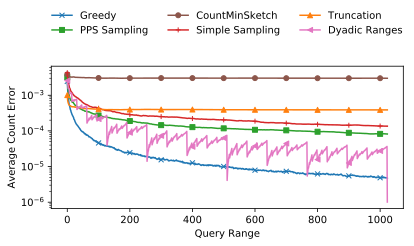

In [189]:
mr = plot_range_results(cum_results[4])

In [210]:
methods = [
    "incremental", 
    "pps", 
#     "spacesaving", 
    "cms_min", 
    "random_sample", 
    "truncation",
    "dyadic_truncation",
    "zero_est"
]
def plot_grain_results(grains, grain_results):
    method_results = {
        "random_sample": [],
        "truncation": [],
        "pps": [],
        "incremental": [],
        "cms_min": [],
        "dyadic_truncation": [],
        "zero_est": []
    }

    for grain_idx in range(len(grains)):
        grain = grains[grain_idx]
        cur_grain_results = grain_results[grain_idx]
        for cur_method in cur_grain_results.keys():
            if cur_method != "topvalue":
                cur_errors = cur_grain_results[cur_method] - cur_grain_results["topvalue"]
                rmse = np.sqrt(np.mean(cur_errors**2)) / 500000
                method_results[cur_method].append(rmse)
    
    plt.figure()
    for method in methods:
        plt.loglog(
            grains,
            method_results[method],
            label=alg_display_name[method],
            marker=markers[method],
            color=colormap[method],
            markersize=5,
        )
#         plt.ylim(.1,1000)
        plt.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3)
        plt.xlabel("# Segments")
        plt.ylabel("Average Count Error")
        plt.tight_layout()
    return method_results


In [196]:
single_query_results = []
for grain_idx in range(len(grains)):
    cur_cum_results = cum_results[grain_idx]
    cur_grain_query_results = {}
    for method in cur_cum_results.keys():
        cur_grain_query_results[method] = cur_cum_results[method][-1]
    single_query_results.append(cur_grain_query_results)

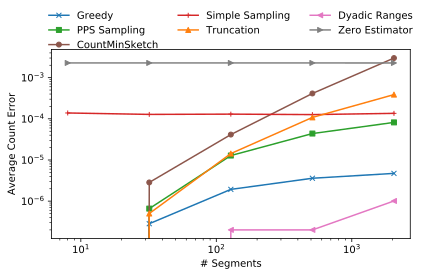

In [211]:
mr = plot_grain_results(grains, single_query_results)

# Old

In [3]:
def count_to_vec(x_counts, max_val):
    counts = np.zeros(max_val)
    for i in range(max_val):
        counts[i] = x_counts.get(i,0)
    return counts

In [20]:
def combine_counts(counts):
    combined = dict()
    for cur_count in counts:
        for k,v in cur_count.items():
            combined[k] = combined.get(k, 0) + v
    return combined

In [60]:
def rmse(x):
    return np.sqrt(np.mean(x**2))

# Multi Grain

In [139]:
# Caida
grains = [8, 32, 128, 512, 2048]
grain_results = []
for cur_grain in grains:
    with open("../output/grain_caida_{}.out".format(cur_grain)) as f:
        results = ast.literal_eval(f.read())
        grain_results.append(results)

In [111]:
# Synthetic
grains = [8, 32, 128, 512, 2048]
grain_results = []
for cur_grain in grains:
    with open("../output/grain_{}.out".format(cur_grain)) as f:
        results = ast.literal_eval(f.read())
        grain_results.append(results)

In [5]:
def calc_day(result_list, grain):
    start_idx = 1*grain/2
    end_idx = 2*grain/2
    max_height = int(math.log2(grain))
    method_results = {
        "topvalue": 0,
        "random_sample": 0,
        "truncation": 0,
        "pps": 0,
        "incremental": 0,
        "spacesaving": 0,
        "cms_min": 0,
        "dyadic_truncation": 0,
    }
    for cur_result in result_list:
        cur_idx = cur_result["seg_idx"]
        cur_method = cur_result["method"]
        cur_counts = cur_result["counts"]
        if isinstance(cur_idx, int):
            if cur_idx >= start_idx and cur_idx < end_idx:
                method_results[cur_method] += count_to_vec(cur_counts, 400)
        else:
            if cur_idx[0] == max_height-1 and cur_idx[1] == grain-1:
                method_results[cur_method] += count_to_vec(cur_counts, 400)
                print(cur_idx)
    return method_results

In [140]:
def calc_query_range(result_list, grain):
    start_idx = 1*grain//2
    end_idx = 2*grain//2
    max_height = int(math.log2(grain))
    method_results_seq = {
        "topvalue": [],
        "random_sample": [],
        "truncation": [],
        "pps": [],
        "incremental": [],
        "spacesaving": [],
        "cms_min": [],
        "dyadic_truncation": [],
    }
    method_values = {
        "topvalue": 0,
        "random_sample": 0,
        "truncation": 0,
        "pps": 0,
        "incremental": 0,
        "spacesaving": 0,
        "cms_min": 0,
    }
    dyadic_values = {}
    
    for cur_result in tqdm(result_list):
        cur_idx = cur_result["seg_idx"]
        cur_method = cur_result["method"]
        cur_counts = cur_result["counts"]
        if isinstance(cur_idx, int):
            if cur_idx >= start_idx:
                method_values[cur_method] += count_to_vec(cur_counts, 400)
                method_results_seq[cur_method].append(np.copy(method_values[cur_method]))
        elif cur_method == "dyadic_truncation":
            c_height, c_start_idx = cur_idx
            if c_start_idx >= start_idx and c_start_idx - 2**c_height >= start_idx-1:
                dyadic_values = {
                    (h, s_idx): counts for ((h, s_idx), counts) in dyadic_values.items()
                    if s_idx > c_start_idx or s_idx - 2**h < c_start_idx - 2**c_height
                }
                dyadic_values[(c_height, c_start_idx)] = cur_counts
                new_final_count = count_to_vec(combine_counts(dyadic_values.values()), 400)
                if (c_start_idx-start_idx) >= len(method_results_seq[cur_method]):
                    method_results_seq[cur_method].append(new_final_count)
                else:
                    method_results_seq[cur_method][c_start_idx-start_idx] = new_final_count
    print(dyadic_values.keys())
    return method_results_seq

In [141]:
methods = [
    "incremental", 
    "pps", 
#     "spacesaving", 
    "cms_min", 
    "random_sample", 
    "truncation",
    "dyadic_truncation",
    "zero_est"
]

In [143]:
query_ranges = calc_query_range(grain_results[4], grains[4])
query_ranges["zero_est"] = [np.zeros(400) for i in range(len(query_ranges["topvalue"]))]


dict_keys([(10, 2047)])


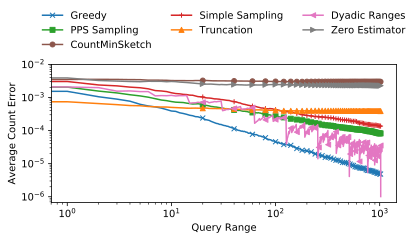

In [144]:
mr = plot_range_results(query_ranges)

In [156]:
methods = [
    "incremental", 
    "pps", 
#     "spacesaving", 
    "cms_min", 
    "random_sample", 
    "truncation",
    "dyadic_truncation",
]
def plot_grain_results(grains, grain_results):
    method_results = {
        "random_sample": [],
        "truncation": [],
        "pps": [],
        "incremental": [],
        "spacesaving": [],
        "cms_min": [],
        "dyadic_truncation": [],
    }

    for grain_idx in range(len(grains)):
        grain = grains[grain_idx]
        day_counts = calc_day(grain_results[grain_idx], grain)
        for cur_method in method_results.keys():
            cur_errors = day_counts[cur_method] - day_counts["topvalue"]
            rmse = np.sqrt(np.mean(cur_errors**2)) / 500000
            method_results[cur_method].append(rmse)
    
    plt.figure()
    for method in methods:
        plt.loglog(
            grains,
            method_results[method],
            label=alg_display_name[method],
            marker=markers[method],
            color=colormap[method],
            markersize=5,
        )
#         plt.ylim(.1,1000)
        plt.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3)
        plt.xlabel("# Segments")
        plt.ylabel("Average Count Error")
        plt.tight_layout()
    return method_results


(2, 7)
(4, 31)
(6, 127)
(8, 511)
(10, 2047)


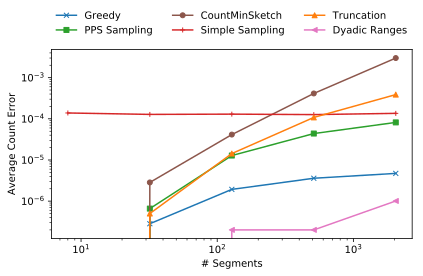

In [157]:
# caida
_ = plot_grain_results(grains, grain_results)

{'random_sample': [123.66398020442331,
  102.31549247303656,
  121.72222475784773,
  114.67789673690393,
  99.61997791607865],
 'truncation': [0.0,
  1.4866068747318506,
  37.69549044647118,
  142.54839529086252,
  354.92786591080727],
 'pps': [3.866129361523834,
  32.02210657939411,
  63.72001041020457,
  95.14523419041177,
  130.92027602120842],
 'incremental': [0.0,
  2.092844953645635,
  3.9293765408777,
  5.319304465811296,
  6.618912297349165],
 'spacesaving': [5.972018084366456,
  35.502675955482566,
  61.81241784625481,
  82.63507124701957,
  145.8301409174386],
 'cms_min': [1.969771560359221,
  37.18205212195798,
  404.908372351079,
  2389.796035229785,
  12148.445447875214]}

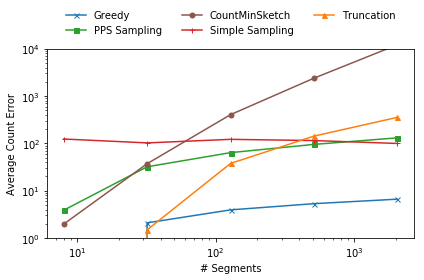

In [112]:
plot_grain_results(grains, grain_results)

In [14]:
final_seg_counts = calc_final_seg(grain_results[4], 2048)
method_err = {
    "random_sample": 0,
    "truncation": 0,
    "pps": 0,
    "incremental": 0,
    "spacesaving":0,
    "cms_min": 0,
}
for cur_method in method_results.keys():
    cur_errors = final_seg_counts[cur_method] - final_seg_counts["topvalue"]
    rmse = np.sqrt(np.mean(cur_errors**2))
    method_err[cur_method] = rmse

TypeError: '>=' not supported between instances of 'tuple' and 'int'

# Single Line

In [36]:
with open("../output/linear_bench.out") as f:
    results = ast.literal_eval(f.read())

In [38]:
seg_counts = {
    "topvalue": [],
    "random_sample": [],
    "truncation": [],
    "pps": [],
    "incremental": [],
    "spacesaving": [],
    "cms_min": [],
    "cms_mean": [],
}
cum_counts = {
    "topvalue": [],
    "random_sample": [],
    "truncation": [],
    "pps": [],
    "incremental": [],
    "spacesaving": [],
    "cms_min": [],
    "cms_mean": [],
}
tot_counts = {
    "topvalue": 0,
    "random_sample": 0,
    "truncation": 0,
    "pps": 0,
    "incremental": 0,
    "spacesaving": 0,
    "cms_min": 0,
    "cms_mean": 0,
}
for cur_result in results:
    method_name = cur_result["method"]
    cur_vec = count_to_vec(cur_result["counts"], 100)
    seg_counts[method_name].append(cur_vec)
    tot_counts[method_name] += cur_vec
    cum_counts[method_name].append(np.copy(tot_counts[method_name]))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


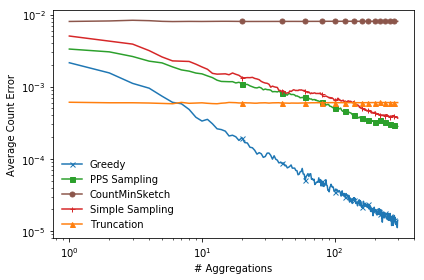

In [39]:
errors_over_time = {
    "topvalue": [],
    "random_sample": [],
    "truncation": [],
    "pps": [],
    "incremental": [],
    "cms_min": []
}
n_segs = len(cum_counts["topvalue"])
start_idx = n_segs//4
# start_idx = 0
for method in ["incremental", "pps", "cms_min", "random_sample", "truncation"]:
    for idx in range(start_idx, n_segs):
        cur_vec = cum_counts[method][idx] - cum_counts[method][start_idx]
        top_vec = cum_counts["topvalue"][idx] - cum_counts["topvalue"][start_idx]
        tot_counts = (idx-start_idx)*1000
        cur_error = np.mean(np.abs(cur_vec-top_vec)/tot_counts)
        errors_over_time[method].append(cur_error)
    errors_over_time[method] = np.array(errors_over_time[method])
#     print("{}:{}".format(
#         method,
#         np.mean(np.abs(tot_counts[method]-tot_counts["topvalue"]))
#     ))
    plt.loglog(
        errors_over_time[method],
        label=alg_display_name[method],
        marker=markers[method],
        color=colormap[method],
             markevery=20,
        markersize=5,
    )
#     plt.ylim(1,10)
plt.legend(frameon=False)
plt.xlabel("# Aggregations")
plt.ylabel("Average Count Error")
plt.tight_layout()
# plt.savefig("linear_balance.pdf")

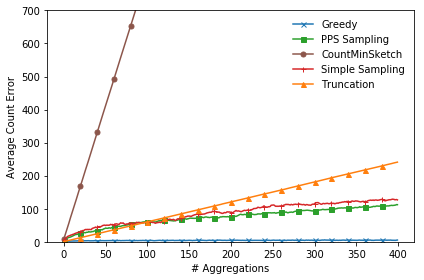

In [40]:
errors_over_time = {
    "topvalue": [],
    "random_sample": [],
    "truncation": [],
    "pps": [],
    "incremental": [],
    "cms_min": []
}
for method in ["incremental", "pps", "cms_min", "random_sample", "truncation"]:
    for idx,cur_vec in enumerate(cum_counts[method]):
        cur_error = np.mean(np.abs(cur_vec-cum_counts["topvalue"][idx]))
        errors_over_time[method].append(cur_error)
    errors_over_time[method] = np.array(errors_over_time[method])
#     print("{}:{}".format(
#         method,
#         np.mean(np.abs(tot_counts[method]-tot_counts["topvalue"]))
#     ))
    plt.plot(errors_over_time[method],
        label=alg_display_name[method],
        marker=markers[method],
        color=colormap[method],
             markevery=20,
        markersize=5,
    )
    plt.ylim(0,700)
plt.legend(frameon=False)
plt.xlabel("# Aggregations")
plt.ylabel("Average Count Error")
plt.tight_layout()
plt.savefig("linear_balance.pdf")

In [79]:
for method in ["incremental", "pps", "spacesaving", "random_sample", "truncation"]:
    print("{}:{}".format(
        method,
        np.max(np.abs(tot_counts[method]-tot_counts["topvalue"]))
    ))

incremental:19.0
pps:535.0
spacesaving:748.0
random_sample:748.0
truncation:498.0
